In [640]:
import pandas as pd 
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 200)

In [777]:
path = '/Users/macintosh/Desktop/data_completitions/Kaggle/2023/icr-identify-age-related-conditions'
df_greeks = pd.read_csv(path+'/greeks.csv')
df_sample_sub = pd.read_csv(path+'/sample_submission.csv')
df_test = pd.read_csv(path+'/test.csv')
df_train = pd.read_csv(path+'/train.csv')

In [778]:
df_greeks.columns = df_greeks.columns.str.lower().str.replace(' ', '')
df_sample_sub.columns = df_sample_sub.columns.str.lower().str.replace(' ', '')
df_test.columns = df_test.columns.str.lower().str.replace(' ', '')
df_train.columns = df_train.columns.str.lower().str.replace(' ', '')

In [779]:
merge_df = df_train.merge(df_greeks, how='left', left_on='id', right_on='id')

In [780]:
# New features
# Alpha
feature_alpha_df = pd.get_dummies(merge_df['alpha'])
feature_alpha_df.columns = 'alpha_'+(feature_alpha_df.columns).str.lower()
# Gamma E, H, A, B flag
feature_gamma_df = pd.get_dummies(merge_df['gamma'])
SELECTED_GAMMA = ['A', 'B', 'E', 'H']
feature_gamma_df = feature_gamma_df.loc[:,SELECTED_GAMMA]
feature_gamma_df.columns = 'gamma_'+(feature_gamma_df.columns).str.lower() 
# Unknown year
merge_df['is_unknown'] = merge_df.epsilon.apply(lambda x: True if x == 'Unknown' else False)

# Concat features
merge_df = pd.concat([merge_df, feature_alpha_df, feature_gamma_df], axis=1)

In [781]:
model = {}

In [782]:
exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
                , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown']
PRE_FEATURES = [c for c in merge_df.columns if c not in exclude_cols]

In [783]:
ALL_IDS = merge_df.id.unique()
oof_alpha_a = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_a = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_b = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_e = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_h = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [784]:
def predict_feature(model_dict, model_name, data, output_data, features):
    # Train with GroupKFold
    gkf = GroupKFold(n_splits=5)
    for i, (train_idx, test_idx) in enumerate(gkf.split(X=data, groups=data.index)):
        print('-'*25)
        print('--- Fold', i+1)
        print('-'*25)
        lgb_params={
            'objective': 'binary',
            'metric': 'auc',
            'learning': 0.002,
            'max_depth': 6,
            'num_iterations':1000
        }
        # Train Data
        train_x = data.iloc[train_idx]
        train_y = data.loc[train_idx]

        # Valid Data
        valid_x = data.iloc[test_idx]
        valid_ids = valid_x.id.values

        # Train Model
        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x[features], train_y[f'{model_name}'])

        # # Save Model
        model_dict[f'{model_name}'] = clf
        output_data.loc[valid_ids] = clf.predict_proba(valid_x[features])
    return output_data
    

In [785]:
# Predict features
oof_alpha_a = predict_feature(model, 'alpha_a', merge_df, oof_alpha_a, PRE_FEATURES)
oof_gamma_a = predict_feature(model, 'gamma_a', merge_df, oof_gamma_a, PRE_FEATURES)
oof_gamma_b = predict_feature(model, 'gamma_b', merge_df, oof_gamma_b, PRE_FEATURES)
oof_gamma_e = predict_feature(model, 'gamma_e', merge_df, oof_gamma_e, PRE_FEATURES)
oof_gamma_h = predict_feature(model, 'gamma_h', merge_df, oof_gamma_h, PRE_FEATURES)

-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


In [786]:
model

{'alpha_a': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_a': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_b': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_e': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_h': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary')}

In [787]:
# Actual label
actual_alpha_a = oof_alpha_a.copy()
actual_alpha_a['alpha_a'] = merge_df.alpha_a.values
actual_gamma_a = oof_gamma_a.copy()
actual_gamma_a['gamma_a'] = merge_df.gamma_a.values
actual_gamma_b = oof_gamma_b.copy()
actual_gamma_b['gamma_b'] = merge_df.gamma_b.values
actual_gamma_e = oof_gamma_e.copy()
actual_gamma_e['gamma_e'] = merge_df.gamma_e.values
actual_gamma_h = oof_gamma_h.copy()
actual_gamma_h['gamma_h'] = merge_df.gamma_h.values

In [788]:
from sklearn.metrics import f1_score
def threshold_selected(output_data, actual):
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.2, 0.81, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (output_data.values.reshape((-1))>threshold).astype('int') 
        m = f1_score(actual.values.reshape((-1)).astype('int'), preds, average='macro') 
        scores.append(m) 
        thresholds.append(threshold)
        if m>best_score:
            best_score = m 
            best_threshold = threshold
    return best_threshold

In [789]:
# Selected threshold
alpha_a_threshold = threshold_selected(oof_alpha_a['class_1'], actual_alpha_a['alpha_a'])
gamma_a_threshold = threshold_selected(oof_gamma_a['class_1'], actual_gamma_a['gamma_a'])
gamma_b_threshold = threshold_selected(oof_gamma_b['class_1'], actual_gamma_b['gamma_b'])
gamma_e_threshold = threshold_selected(oof_gamma_e['class_1'], actual_gamma_e['gamma_e'])
gamma_h_threshold = threshold_selected(oof_gamma_h['class_1'], actual_gamma_h['gamma_h'])

0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62

In [790]:
gamma_h_threshold

0.22000000000000003

In [791]:
def feature_flag(data, threshold):
    return data.class_1.apply(lambda x: 1 if x >= threshold else 0)

In [792]:
# Predict alpha_a feature
oof_alpha_a['alpha_a_flag'] = feature_flag(oof_alpha_a, alpha_a_threshold)
oof_alpha_a = oof_alpha_a.reset_index()
oof_gamma_a['gamma_a_flag'] = feature_flag(oof_gamma_a, gamma_a_threshold)
oof_gamma_a = oof_gamma_a.reset_index()
oof_gamma_b['gamma_b_flag'] = feature_flag(oof_gamma_b, gamma_b_threshold)
oof_gamma_b = oof_gamma_b.reset_index()
oof_gamma_e['gamma_e_flag'] = feature_flag(oof_gamma_e, gamma_e_threshold)
oof_gamma_e = oof_gamma_e.reset_index()
oof_gamma_h['gamma_h_flag'] = feature_flag(oof_gamma_h, gamma_h_threshold)
oof_gamma_h = oof_gamma_h.reset_index()


In [793]:
concat_list = [merge_df, oof_alpha_a['alpha_a_flag'], oof_gamma_a['gamma_a_flag'], oof_gamma_b['gamma_b_flag']
               , oof_gamma_e['gamma_e_flag'], oof_gamma_h['gamma_h_flag']]
# concat_list = [merge_df, oof_alpha_a['alpha_a_flag']]
merge_df = pd.concat(concat_list, axis=1)
merge_df['gamma_flag'] = merge_df['gamma_a_flag'] + merge_df['gamma_b_flag'] + merge_df['gamma_e_flag'] + merge_df['gamma_h_flag']

In [695]:
# # Find best threshold
# from sklearn.metrics import f1_score
# # Find best threshold to convert probs into 1s and 0s
# scores = []; thresholds = []
# best_score = 0; best_threshold = 0

# for threshold in np.arange(0.2, 0.81, 0.01): # np.arange(start, end(but not include), step) 
#     # but why use range at 0.4 - 0.8? --> i assume that proper range to identify that good or bad threshold
#     print(f'{threshold:.02f}, ', end='')
#     preds = (oof_alpha_a['class_1'].values.reshape((-1))>threshold).astype('int') #get all pred values and check if > threshold then true and covert true to int vice versa with false
#     m = f1_score(actual['alpha_a'].values.reshape((-1)).astype('int'), preds, average='macro') # make sure that actual & predict same type if not will cause error 
#     scores.append(m) # collect data because this use for plot
#     thresholds.append(threshold) # collect data because this use for plot
#     # this part below just collect best score & threshold
#     if m>best_score:
#         best_score = m 
#         best_threshold = threshold

0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 

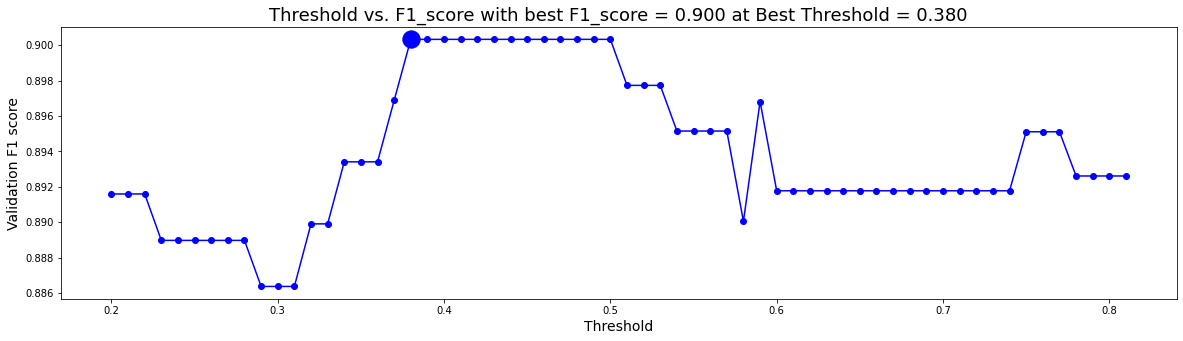

In [696]:
# import matplotlib.pylab as plt
# # Plot Threshold vs F1 score
# plt.figure(figsize=(20,5))
# plt.plot(thresholds, scores, '-o', color='blue') # plot all threshold & scores
# plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1) # make best point are more bigger
# plt.xlabel('Threshold', size = 14)
# plt.ylabel('Validation F1 score', size = 14)
# plt.title(f'Threshold vs. F1_score with best F1_score = {best_score:.3f} at Best Threshold = {best_threshold:.3f}', size = 18)
# plt.show()

In [697]:
# best_threshold

0.38000000000000017

In [808]:

# exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
#                 , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown']
# FEATURES = [c for c in merge_df.columns if c not in exclude_cols]
# df_tr = merge_df[FEATURES] 
# df_tr_label = merge_df[['class']]
# merge_df.head()
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'gamma_flag']
FINAL_FEATURES = ['alpha_a_flag', 'gamma_flag']

In [809]:
ALL_IDS = merge_df.id.unique()
oof = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [810]:
oof = predict_feature(model, 'class', merge_df, oof, FINAL_FEATURES)


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [811]:
oof.head()

,class_0,class_1
000ff2bfdfe9,0.076923,0.923077
007255e47698,0.946731,0.053269
013f2bd269f5,0.959427,0.040573
043ac50845d5,0.954545,0.045455
044fb8a146ec,0.961894,0.038106


In [812]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight=1/nc[y_true], eps=1e-15)

In [813]:
y_true = merge_df['class']
y_pred = oof['class_1']
balanced_log_loss(y_true, y_pred)
# Best score is 0.7449367545977311
# now is 6.823326702712194e-06?

0.436271978569661

In [733]:
y_pred

000ff2bfdfe9    9.999494e-01
007255e47698    1.510898e-08
013f2bd269f5    2.053474e-06
043ac50845d5    1.217717e-05
044fb8a146ec    3.235972e-05
                    ...     
fd3dafe738fd    4.407488e-07
fd895603f071    5.364325e-05
fd8ef6377f76    1.226446e-08
fe1942975e40    3.035087e-08
ffcca4ded3bb    3.551544e-08
Name: class_1, Length: 617, dtype: float64